### Transforms convolutional

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from functools import partial

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [3]:
# crop size
cihna_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
image_resized_and_crop = tf.image.crop_and_resize(images, [cihna_box, flower_box], [0,1], [224,224])

In [10]:
xx=tf.constant([
  [[0, 1, 2, 3, 4],
   [5, 6, 7, 8, 9]],
  [[10, 11, 29, 13, 14],
   [15, 16, 17, 18, 19]],
  [[20, 21, 22, 23, 24],
   [25, 26, 27, 28, 12]]
])
tf.reduce_max(xx).numpy()

29

In [8]:
X.shape

(2, 224, 224, 3)

In [6]:
X = image_resized_and_crop.numpy()
conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3,strides=2,padding='VALID')
output = conv_transpose(X)
output

<tf.Tensor: shape=(2, 449, 449, 5), dtype=float32, numpy=
array([[[[-2.35138983e-01,  4.11510617e-02, -2.44431540e-01,
          -1.81506183e-02, -2.02686619e-02],
         [-1.66219808e-02, -2.82684624e-01, -2.53879368e-01,
          -1.34427711e-01,  2.66315997e-01],
         [-5.76706111e-01,  1.39010832e-01,  3.46804112e-02,
          -2.29543731e-01,  1.25522628e-01],
         ...,
         [-6.76130712e-01,  1.82532251e-01,  1.36470795e-02,
          -3.04764479e-01,  1.32497907e-01],
         [-5.46334125e-02, -3.24378312e-01, -2.57151097e-01,
          -1.32422358e-01,  3.05859685e-01],
         [-3.98254991e-01,  1.47471204e-01,  3.04421455e-01,
          -2.76689440e-01,  1.32901683e-01]],

        [[-4.23019022e-01,  7.81632066e-02,  2.98320681e-01,
           1.38383105e-01,  9.70761478e-02],
         [-1.32335760e-02,  7.77410567e-02, -2.78251290e-01,
           1.87128395e-01, -1.00845814e-01],
         [-2.91164815e-02, -1.83694810e-01,  6.32526129e-02,
           4.5396

In [5]:
def normalize(X):
    norm = (X - tf.reduce_min(X) / (tf.reduce_max(X) - tf.reduce_min(X)))
    return norm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


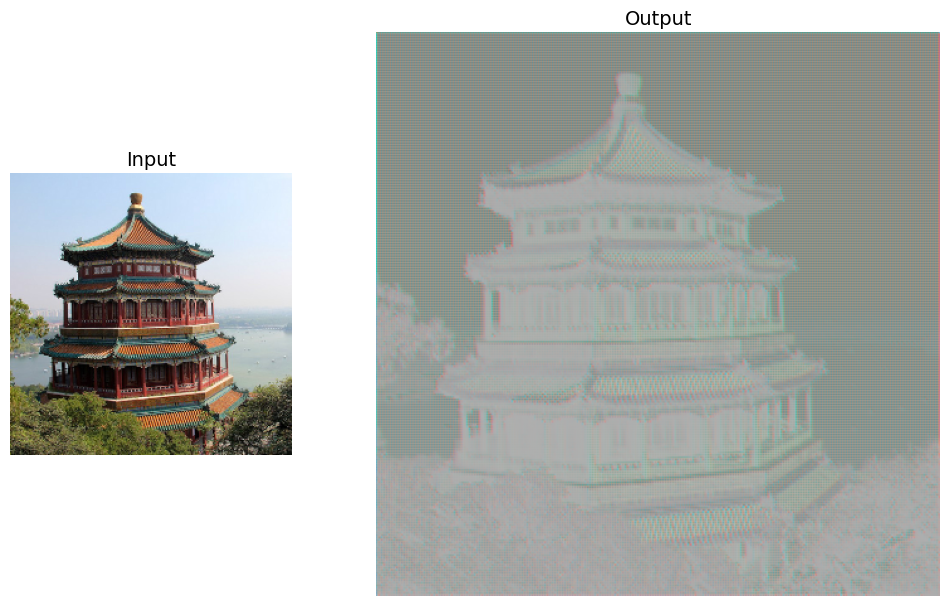

In [7]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()